# CPD Options

The *cpd* function has several options at disposal. Some of them may improve performance, precision or give insights about the tensor at hand. If you look at the source code, the first line of *cpd* is the following:

    def cpd(T, r, options=False):

The first action of the **cpd** function is to use the variable *options* as input to the **make_options** function. When set to False, this function set the parameters to their default values. In order to change some of them the user needs to create a class *options* and add the parameter of interested with its corresponding value. The class with all the default parameters is showed below:

    class options:
        maxiter = 200 
        tol = 1e-12  
        maxiter_refine = 200
        tol_refine = 1e-10
        init = 'smart_random'
        trunc_dims = 0
        level = 1
        refine = False
        symm = False
        low = 0
        upp = 0
        factor = 0
        trials = 10
        display = 0

We explain them one by one now, not in the order above but in a more didatic order. Let's start importing the necessary modules. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import TensorFox as tfx

# Trials

Tensor Fox has two distinct approaches when it comes to computing the CPD of third order tensors and higher order tensors. For third order tensors the program relies on an algorithm called *Damped Gauss-Newton* (dGN). For higher order tensors the program relies on the *Tensor Train format* (TT format), aldo called *Tensor Train decomposition*. Without going in too much details, we use a specific configuration of the TT format which can be obtained by computing several third order CPD's. More precisely, if $T$ is a tensor of order $L$, then we can compute a CPD for it by computing $L-2$ third order CPD's. Once we have the TT format of $T$, the CPD can also be computed.

In the case $T$ has order higher than $3$, the parameter *trials* defines how much times we compute each one of these third order CPD's. The idea is to compute several times and keep the best result (smaller error). This may be helpful because all $L-2$ CPD's needs to be of good quality in order to get a good CPD for $T$. If anyone of the third order CPD's has bad precision, than everything falls apart. Currently the default is *trials*$= 10$, but this may change depending on the problem. This parameter doesn't makes difference if $T$ is a third order tensor.

# Display

There are four choices for the *display* option: $-1,0,1,2,3$. These options controls what the user can see during the computations. In the previous lesson we let the default option and there were no output whatsoever (default is $0$). The option $1$ shows useful information about the principal stages of the computation, option $2$ shows everything the option $1$ shows plus information about each iteration. The option $3$ is special, it shows eveything the option $2$ shows and also shows the relative error of the compressed tensor. The computation of this error is costly so avoid that for big tensors. The option $-1$ is special for it is reserved for tensors of order higher than $3$. We'll see more about that in a few moments. To see how this parameter affects works, let's start creating out toy model tensor.

In [2]:
# Create and print the tensor.
m = 2
T = np.zeros((m, m, m))
s = 0

for k in range(m):
    for i in range(m):
        for j in range(m):
            T[i,j,k] = s
            s += 1
                    
tfx.disp.showtens(T)

[[0. 1.]
 [2. 3.]]

[[4. 5.]
 [6. 7.]]



In [3]:
# Create class of options with display=1.
class options:
    display = 1

# Compute the CPD of T with partial display.
r = 3
factors, T_approx, output = tfx.cpd(T, r, options)

--------------------------------------------------------------------------
Computing MLSVD of T
    No compression detected
    Working with dimensions (2, 2, 2)
--------------------------------------------------------------------------
Type of initialization: smart_random
--------------------------------------------------------------------------
Computing CPD of T
Final results
    Number of steps = 32
    Relative error = 4.4065035003667347e-07
    Accuracy =  99.99996 %


In [4]:
# Compute the CPD of T with full display.
options.display = 2
factors, T_approx, output = tfx.cpd(T, r, options)

--------------------------------------------------------------------------
Computing MLSVD of T
    No compression detected
    Working with dimensions (2, 2, 2)
--------------------------------------------------------------------------
Type of initialization: smart_random
--------------------------------------------------------------------------
Computing CPD of T
    Iteration | Rel Error  | Rel Error Diff |     ||g||    | Damp| #CG iterations
        1     |  0.541679  |    0.541679    |  22.094277  | 3.5 |    1
        2     |  0.417621  |    0.124058    |  18.082283  | 3.5 |    2
        3     |  0.255312  |    0.162309    |  14.894176  | 1.75 |    2
        4     |  0.156411  |    0.098901    |  9.770509  | 1.75 |    3
        5     |  0.097786  |    0.058624    |  5.980641  | 1.75 |    2
        6     |  0.062021  |    0.035765    |  3.602723  | 1.75 |    2
        7     |  0.029409  |    0.032613    |  2.169544  | 0.875 |    3
        8     |  0.017089  |    0.012320    |  0.94

In [5]:
# Compute the CPD of T with full display plus relative error of compression.
options.display = 3
factors, T_approx, output = tfx.cpd(T, r, options)

--------------------------------------------------------------------------
Computing MLSVD of T
    No compression detected
    Working with dimensions (2, 2, 2)
    Compression relative error = 0.0
--------------------------------------------------------------------------
Type of initialization: smart_random
    Initial guess relative error = 0.73282
--------------------------------------------------------------------------
Computing CPD of T
    Iteration | Rel Error  | Rel Error Diff |     ||g||    | Damp| #CG iterations
        1     |  0.501426  |    0.501426    |  23.082523  | 3.5 |    1
        2     |  0.349668  |    0.151758    |  15.069251  | 3.5 |    2
        3     |  0.215730  |    0.133938    |  9.677591  | 1.75 |    2
        4     |  0.153129  |    0.062602    |  4.709201  | 1.75 |    2
        5     |  0.100246  |    0.052882    |  2.568739  | 0.875 |    2
        6     |  0.064162  |    0.036084    |  1.209929  | 0.438 |    2
        7     |  0.039721  |    0.024441  

As we've said, the options *trials* says about the repetition of third order CPD computations. If *display* is set to $1,2$ or $3$, then all the information of each one of these CPD's are printed on the screen. This means we wil have $(L-2) \cdot trials$ CPD's informations printed on the screen when $T$ has order $L$ . Sometimes this amount of information is just too much. We can make everything more succint in these situations just by setting *display* $=-1$. Consider the following fourth order tensor.

In [6]:
# Initialize dimensions of the tensor.
m = 2
dims = (m, m, m, m)
L = len(dims)

# Create four random factors matrices so thar 
# A = (orig_factors[0], orig_factors[1], orig_factors[2], orig_factors[3])*I.
orig_factors = []
for l in range(L):
    M = np.random.randn(m,r)
    Q, R = np.linalg.qr(M)
    orig_factors.append(Q)
    
# From the factor matrices generate the respective tensor in coordinates.
A = tfx.cnv.cpd2tens(orig_factors, dims)

print('A = ')
tfx.disp.showtens(A)

A = 
[[[[ 0.33921401 -0.29417468]
   [-0.03283426 -0.35823537]]

  [[ 0.25365394 -0.61660903]
   [ 0.34590414 -0.32370936]]]


 [[[ 0.32370936  0.34590414]
   [-0.61660903 -0.25365394]]

  [[-0.35823537  0.03283426]
   [ 0.29417468  0.33921401]]]]


In [7]:
# Compute the CPD of A with succint display for higher order tensors.
options.display = -1
r = 2
factors, A, output = tfx.cpd(A, r, options)

Total of 2 third order CPDs to be computed:
1 ) CPD error = 1.634835018262044e-06
2 ) CPD error = 1.730093619433488e-06

Final results
    Number of steps = 65
    Relative error = 1.2941994721353102e-06
    Accuracy =  99.99987 %


In [8]:
# The user may be interested in seeing how each third order CPD is computed.
options.display = 1
factors, A, output = tfx.cpd(A, r, options)

Total of 2 third order CPDs to be computed:

CPD 1
--------------------------------------------------------------------------
Computing MLSVD of T
    No compression detected
    Working with dimensions (2, 2, 2)
--------------------------------------------------------------------------
Type of initialization: smart_random
--------------------------------------------------------------------------
Computing CPD of T
Final results
    Number of steps = 23
    Relative error = 1.2023700333075451e-06
    Accuracy =  99.99988 %

CPD 2
--------------------------------------------------------------------------
Computing MLSVD of T
    No compression detected
    Working with dimensions (2, 2, 2)
--------------------------------------------------------------------------
Type of initialization: fixed + smart_random
--------------------------------------------------------------------------
Computing CPD of T
Final results of bicpd
    Number of steps = 200
    Relative error = 0.0010512402857538

# Initialization

The iteration process needs a starting point for iterating. This starting point depends on the *init* option, and there are three possible choices in this case: *smart*, *smart_random* (default), *random*, and *user*. Both *smart* and *smart_random* options generates a random CPD of rank $r$ with a strategy relying on the MLSVD. The smart one maximizes the energy of the initialization while the smart random makes almost the same, but with a chance to take some different entries. These strategies generates starting points with small relative error, so it is already close to the objective tensor. The *random* option generates a CPD of rank $r$ with entries drawn from the Normal Distribution. The relative error in this case usually is close to $1$. Finally, there is the 'user' option where the user provides a list $[X, Y, Z]$ as starting point. This is a good idea when the user already have a close CPD $T \approx (X, Y, Z) \cdot I$ and want to increase the precision.

In [9]:
# Compute the CPD of T with random initialization.
options.display = 1
options.init = 'random'
factors, T_approx, output = tfx.cpd(T, r, options)

--------------------------------------------------------------------------
Computing MLSVD of T
    No compression detected
    Working with dimensions (2, 2, 2)
--------------------------------------------------------------------------
Type of initialization: random
--------------------------------------------------------------------------
Computing CPD of T
Final results
    Number of steps = 46
    Relative error = 0.0002284065173623091
    Accuracy =  99.97716 %


In [10]:
# Compute the CPD of T with user initialization.
X = np.ones((m, r))
Y = np.ones((m, r))
Z = np.ones((m, r))
options.init = [X,Y,Z]
factors, T_approx, info = tfx.cpd(T, r, options)

--------------------------------------------------------------------------
Computing MLSVD of T
    No compression detected
    Working with dimensions (2, 2, 2)
--------------------------------------------------------------------------
Type of initialization: user
--------------------------------------------------------------------------
Computing CPD of T
Final results
    Number of steps = 11
    Relative error = 0.1307980712488536
    Accuracy =  86.92019 %


# Refinement

As we mentioned before, the user may give an initial CPD as starting point for our iterative algorithm, which may be a good idea when it is desired to increase the precision of the CPD. This process can be done automatically by setting *refine* to True. This option makes the program runs the algorithm two times, where the second run uses the approximated CPD computed in the first run as starting point.

Since this is an easy problem, the refinement stage doesn't help (in other words, the first run was already good enough). Note that the refinement stage doesn't just continues iterating, which would be the same as just making more iterations. In fact, the damping factor is reset so the problem becomes very regularized. Sometimes this repeated regularization can be useful. Furthermore, starting again has an effect on the number of number of conjugate gradient iterations.

In [11]:
# Compute the CPD of T with refinement.
options.display = 2
options.init = 'smart_random'
options.refine = True
factors, T_approx, output = tfx.cpd(T, r, options)

--------------------------------------------------------------------------
Computing MLSVD of T
    No compression detected
    Working with dimensions (2, 2, 2)
--------------------------------------------------------------------------
Type of initialization: smart_random
--------------------------------------------------------------------------
Computing CPD of T
    Iteration | Rel Error  | Rel Error Diff |     ||g||    | Damp| #CG iterations
        1     |  0.822279  |    0.822279    |  15.186750  | 3.5 |    1
        2     |  0.622457  |    0.199822    |  16.772144  | 3.5 |    2
        3     |  0.261488  |    0.360969    |  17.648721  | 1.75 |    2
        4     |  0.164382  |    0.097106    |  10.051818  | 2.62 |    2
        5     |  0.097831  |    0.066551    |  6.117515  | 1.31 |    4
        6     |  0.076219  |    0.021612    |  2.747492  | 1.31 |    5
        7     |  0.066821  |    0.009397    |  1.343731  | 0.656 |    4
        8     |  0.064378  |    0.002443    |  0.5

# Maximum number of iterations and tolerance

As the names suggest, *maxiter* is the maximum number of iterations permitted, while *tol* is the tolerance parameter, it is used to make stopping criteria. Both values are related in the sense we should increase *maxiter* when we decrease *tol*. Notice we have these parameters for the main stage and the refinement stage. More precisely, *maxiter*, *tol* are used in the first (main) stage and *maxiter_refine*, *tol_refine* are used in the second (refinement) stage. Changing this parameters in this little example might not matter too much but for larger tensors we may want to increase precision by decreasing *tol*, for instance. 

One of the most relevant stopping criteria is the improvement of the relative error criterium. Let $T_{approx}^{(k)}$ be the approximation computed at the $k$ iteration. Then the program stops if 
$$ \left| \frac{\| T - T_{approx}^{(k)} \|}{\| T \|} - \frac{\| T - T_{approx}^{(k-1)} \|}{\| T \|} \right| <  \verb|tol| \cdot mnp,$$
where $m,n,p$ are the dimensions of $T$.

Let's decrease *tol* and see if we get better approximations for the CPD of this example. We use *tol* = 1e-16 and keep the rest with default values.

In [12]:
# Compute the CPD of T with tol = 1e-16.
options.display = 2
options.refine = False
options.tol = 1e-16
factors, T_approx, output = tfx.cpd(T, r, options)

--------------------------------------------------------------------------
Computing MLSVD of T
    No compression detected
    Working with dimensions (2, 2, 2)
--------------------------------------------------------------------------
Type of initialization: smart_random
--------------------------------------------------------------------------
Computing CPD of T
    Iteration | Rel Error  | Rel Error Diff |     ||g||    | Damp| #CG iterations
        1     |  0.823515  |    0.823515    |  15.073844  | 3.5 |    1
        2     |  0.591885  |    0.231630    |  16.758511  | 3.5 |    2
        3     |  0.231190  |    0.360695    |  16.733229  | 1.75 |    2
        4     |  0.157847  |    0.073343    |  6.286148  | 2.62 |    2
        5     |  0.116748  |    0.041099    |  3.182107  | 1.31 |    4
        6     |  0.095247  |    0.021501    |  1.701001  | 0.656 |    3
        7     |  0.076045  |    0.019202    |  0.949463  | 0.328 |    6
        8     |  0.061699  |    0.014346    |  0.6

Note that there is more improvement going on during the iterations, but the display is limited to 6 decimal places. To understad how the tolerance influence the precision we can make a plot varying the tolerances. 

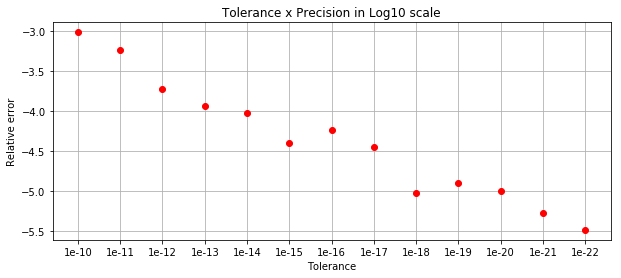

In [13]:
errors = []
options.display = 0
tolerances = [1e-10, 1e-11, 1e-12, 1e-13, 1e-14, 1e-15, 1e-16, 1e-17, 1e-18, 1e-19, 1e-20, 1e-21, 1e-22]
tolerances_str = ['1e-10', '1e-11', '1e-12', '1e-13', '1e-14', '1e-15', '1e-16', '1e-17', '1e-18', '1e-19', '1e-20', '1e-21', '1e-22']

for tolerance in tolerances:
    options.tol = tolerance
    factors, T_approx, output = tfx.cpd(T, r, options)
    errors.append(output.rel_error)
    
plt.figure(figsize=[10,4])
plt.plot(tolerances_str, np.log10(errors), 'ro')
plt.title('Tolerance x Precision in Log10 scale')
plt.xlabel('Tolerance')
plt.ylabel('Relative error')
plt.grid()
plt.show()

# Truncation

Consider a matrix $A \in \mathbb{R}^{m \times n}$ and its reduced SVD 

$$A = U \Sigma V^T = [U_1 \ldots U_n] \cdot \text{diag}(\sigma_1, \ldots, \sigma_n) \cdot [V_1 \ldots V_m]^T.$$ 

It is commom to truncate $\Sigma$ in order to obtain the *truncate SVD* of $A$ given by 

$$\tilde{A} = [U_1 \ldots U_p] \cdot \text{diag}(\sigma_1, \ldots, \sigma_p) \cdot [V_1 \ldots V_p]^T,$$
where $p < n$. This truncated version of $A$ should be seen as a compressed version of $A$. We always work with compressed versions here.

There are several application in this decomposition we won't discuss here. We just want to mention that the sum $\sigma_1^2 + \ldots + \sigma_p^2$ is called the *energy* of $\tilde{A}$. The more energy the truncation has, more close to $A$ it is. On the other hand, less energy means fewer dimensions to take in account, and this translates to less computational time. As you can see, there is a trade off between proximity and dimensionality. We want to truncate as much as possible, but keeping the truncation close enough to $A$. 

In the same way we can compress matrices using the SVD, we can compress tensors using the MLSVD. The parameter *level* imposes thresholds values at the compression stage of $T$. Higher levels means harder constraints, which means bigger dimensions. The level parameter can be $0$, $1$, $2$, $3$, $4$ or $5$, default is *level* $=1$. The larger is this value, the bigger is the threshold value of the energy to stop truncating. Smaller level values means smaller truncations, and bigger level values means bigger truncations. In particular, *level* $= 4$ means to use the compression given by the MLSVD but wothout truncation it. The extreme case is *level* $=5$, where the program used the original tensor without any kind of preprocessing. 

For each choice of *level* the program automatically constructs a truncation, and it may happend that none truncation performs well. In this case the user can manually choose the truncation if needed too. Just set *trunc_dims* = $[m', n', p']$, where 

$$1 \leq m' \leq m,\quad 1 \leq n' \leq n,\quad 1 \leq p' \leq p.$$

Then the truncated tensor have dimensions $m' \times n' \times p'$.

In this example we can note that the truncation stage is unable to truncate. We can force some truncation, say $2 \times 1 \times 1$ ans see if we get good precision of this. The precision can already be antecipated just by seeing the relative error of the compression (remember that this requires setting *display* to $3$, which can be costly). In this case this error is of $0.130828$, which means this is the best precision we can get. As the iterations goes on one can observe that the error (respective to the compressed tensor, not the original) gets to zero, so the final error is the most accurate possible with that limitations, that is, the final error also is $0.130828$.

In [14]:
options.display = 3
options.tol = 1e-12
options.trunc_dims = [2,1,1]
factors, T_approx, output = tfx.cpd(T, r, options)

--------------------------------------------------------------------------
Computing MLSVD of T
    Compression detected
    Compressing from (2, 2, 2) to (2, 1, 1)
    99.31 % of the energy was retained
    Compression relative error = 0.130828
--------------------------------------------------------------------------
Type of initialization: smart_random
    Initial guess relative error = 1.0
--------------------------------------------------------------------------
Computing CPD of T
    Iteration | Rel Error  | Rel Error Diff |     ||g||    | Damp| #CG iterations
        1     |  0.536052  |    0.536052    |  60.560739  | 5.87 |    1
        2     |  0.280791  |    0.255261    |  27.225849  | 5.87 |    2
        3     |  0.170375  |    0.110415    |  12.633889  | 8.81 |    2
        4     |  0.102704  |    0.067671    |  7.218656  | 8.81 |    2
        5     |  0.061620  |    0.041084    |  4.182035  | 8.81 |    2
        6     |  0.036854  |    0.024766    |  2.446364  | 8.81 |    

# Symmetric Tensors

If one want to work with symmetric tensors, just set *symm* to True. With this option activated the initialization and all iterations of the dGN function will be done with symmetric tensors. At each iteration of the dGN function we have an approximated CPD given by the triple $X, Y, Z$. This triple is obtained with the conjugate gradient method. The next step is to set 

$$X = \frac{X+Y+Z}{3},\quad Y = X,\quad Z = X.$$

If the objective tensor is really symmetric, then this procedure converges. Otherwise it can diverge.

# Constraints

These three parameters always work together. Their are used when the user want to add constraints to the tensor entries. More precisely, they produce a solution $T_{approx}$ such that each of its entries are inside the interval $[\verb|low|, \verb|upp|]$. Here is how it works, given the $k$-th approximation $T_{approx}^{(k)}$, denote by $t$ an arbitrary entry of $T_{approx}^{(k)}$. Before computing the $(k+1)$ iteration the program projects each entry $t$ in $[\verb|low|, \verb|upp|]$ through the map
$$t \mapsto \verb|low| + \frac{\verb|upp| - \verb|low|}{1 + e^{-A -Bt}},$$
where
$$A = -B \cdot \frac{\verb|low| + \verb|upp|}{2},$$
$$B = \ln\left( \frac{\verb|upp| - \verb|low|}{\varepsilon} - 1 \right) - \ln\left( \verb|factor| \cdot \frac{\verb|upp| - \verb|low|}{2} - \varepsilon \right),$$
and $\varepsilon > 0$ is small enough (currently we are using $\varepsilon = 0.02$).

This map is the sigmoid function with some specific constants, both depending on the parameter $\verb|factor|$, which is responsible for the stretching level of the curve. This sigmoid maps $\frac{\verb|low| + \verb|upp|}{2}$ as fixed point (it is located at the 'center' of the function) and it has $\verb|low|$ and $\verb|upp|$ as horizontal asymptotes. Below we show nine plots illustrating the behavior of this map.

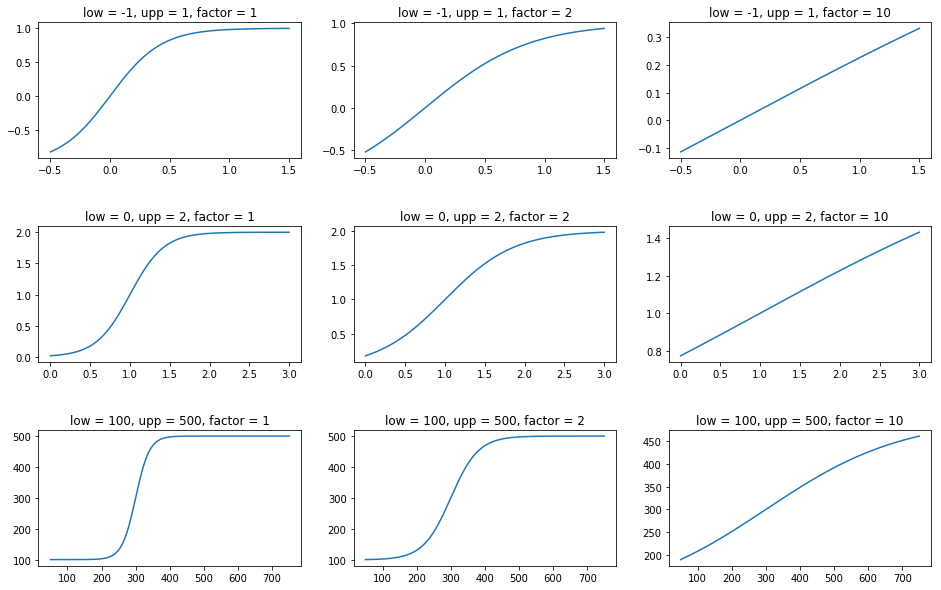

In [15]:
eps = 0.02
# Each entry of the list 'parameters' is a triple (low, upp, factor)
parameters = [[-1,1,1], [-1,1,2], [-1,1,10], [0,2,1], [0,2,2], [0,2,10], [100,500,1], [100,500,2], [100,500,10]]

k = 0
num_rows = 3
num_cols = 3    
fig, ax = plt.subplots(num_rows, num_cols, figsize=(16, 10))    
fig.subplots_adjust(hspace=0.5)
for i in range(num_rows):
    for j in range(num_cols):
        low, upp, factor = parameters[k][0], parameters[k][1], parameters[k][2]
        t = np.linspace(low - low/2, upp + upp/2, 1000)
        B = np.log( (upp-low)/eps - 1 )/( factor*(upp-low)/2 - eps )
        A = -B*(low+upp)/2
        y = low + (upp-low)/(1 + np.exp(-A-B*t))
        ax[i,j].title.set_text('low = ' + str(low) + ', upp = ' + str(upp) + ', factor = ' + str(factor))
        ax[i,j].plot(t, y)
        k += 1
plt.show()

In the example of the tutorial we know that all entries of $T$ are between $0$ and $7$, so we can try to constrain the CPD to this values. This may decrease the number of iterations since we are forcing all entries to be closer to their objective values. since this example is so simple, the difference is unnoticeable.

In [16]:
# CPD with constraints
class options:
    display = 1
    low = 0
    upp = 7
    factor = 1
factors, T_approx, output = tfx.cpd(T, r, options)

--------------------------------------------------------------------------
Computing MLSVD of T
    No compression detected
    Working with dimensions (2, 2, 2)
--------------------------------------------------------------------------
Type of initialization: smart_random
--------------------------------------------------------------------------
Computing CPD of T
Final results
    Number of steps = 64
    Relative error = 0.00039061717568682105
    Accuracy =  99.96094 %


The strategy of constraining the entries may fail depending on the tensor, or it may depend on a good choice of *factors*. Ideally, we want to choose this parameter so it minimizes the error corresponding to the starting point. Doing this manually is possible with the routines of Tensor Fox, but it takes some work. With that in mind we designed a function just for this purpose. This function is called **find_factor** and it tries to find the best parameter *factor* in the interval $[0,100]$, in the sense that the error of the initialization obtained with that choice is minimized. 

Type of initialization: smart_random

First run
[====================================================================================================] 100%
Second run
[====================================================================================================] 100%

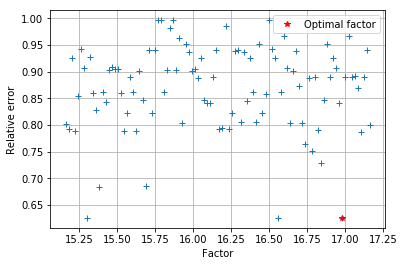


Factor = 16.97979797979798
Error = 0.6257390927352544


In [17]:
Tsize = np.linalg.norm(T)
factor, error = tfx.cnst.find_factor(T, Tsize, r, options, plot=True)
print()
print('Factor =', factor)
print('Error =', error)

We should point out that this factor may change since this initialization has a random component. More structured (and bigger) problems may be more consistent even in the presence of this randomness. This is an extra featured which is still in phase of experimentation.